# Analysis of Financial Time Series with Persistent Homology

<hr>
<hr>

## a. Description

This project's goal is to analyze the evolution of daily returns of four key US stock markets indices (i.e. DowJones, Nasdaq, Russell2000, SP500) over the period 1989 – 2016 using persistent homology, following the approach proposed in "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)" by Marian Gidea and Yuri Katz.

A classical approach in Topological Data Analysis (TDA) to extract topological features from multivariate time-series with values in $R^d$ ($d = 4$ here, since we are considering the evolution of four indices) consists in using a sliding window of fixed length $w$ to generate a sequence of $w$ points in $R^d$.

Using the Vietoris-Rips filtration, the persistence diagram of each of these point clouds is then computed and used as a topological feature for further analysis or processing of the initial data. This project aims at reproducing the experiments in the paper cited above and explore and discuss a few variants.


## b. Notebook Steps

<u>**Step 1**</u> -- Perform simple data exploration on the available dataset and note important/applicable points from the provided article (we will specifically pay attention to Sections 3.1 and 4).

<u>**Step 2**</u> -- Write a function to compute persistence landscapes *WITHOUT* using the GUDHI library. This function should take as input a persistence diagram $D$ (in the GUDHI format), a dimension $k$, the endpoints
$x_{min}$, $x_{max}$ of an interval, the number $n$ of nodes of a regular grid on the interval $[x_{min}, x_{max}]$ and a number of landscapes $m$, and should output an $m \times n$ array storing the values of the first $m$ landscapes of the persistence diagram $D$ on the nodes of the grid. Check on some simple examples that your code
is correct.

<u>**Step 3**</u> -- Use the landscape function to run the experiments done in Section 4 of the paper, using windows of length $w = 40$ and $w = 80$ and $w = 120$. Compare your results to the ones provided in the article: are they similar or not?

<u>**Step 4**</u> -- Propose and experiment other methods, than just computing the norm of landscapes and briefly discuss and compare your results to the ones in Section 4 of the paper.

## c. Library Imports

In [95]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## d. Function Declarations

In [100]:
def compute_log_returns(df):
    """
    Given an input standardized stock price dataframe, transforms
    the dataframe in its relative-valued counterpart:
    - prices are transformed into their log-return
    - volume is transformed into a percent change
    """
    new_df = df.copy()
    price_columns = ["Open", "High", "Low", "Close", "Adj Close"]
    for column in price_columns:
        new_df[column] = np.log(new_df[column]) - np.log(new_df[column].shift(1))
    new_df["Volume"]=new_df["Volume"].pct_change()
    new_df = new_df[1:]
    new_df.index = range(0, 7300)
    return new_df

def plot_price_data(df_list, legend):
    """
    Given a list of standardized stock price data, plots the
    Adjusted Close value across the whole available timeline.
    """
    plt.figure()
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
    for df in df_list:
        plt.plot(df["Date"].tolist(), df[["Adj Close"]])
    plt.xticks(rotation=90)
    plt.legend(legend)
    plt.show()

<hr>
<hr>

# 1. Step 1

### 1.1 Data Exploration

<u>Importing the four stock index .csv files:</u>

In [101]:
# Sets path and file names
dpath = "data/"
files = ["dowjones.csv", "nasdaq.csv", "russel2000.csv", "sp500.csv"]

# Imports
dowjones   = pd.read_csv(dpath+files[0])
nasdaq     = pd.read_csv(dpath+files[1])
russel2000 = pd.read_csv(dpath+files[2])
sp500      = pd.read_csv(dpath+files[3])

<u>Reversing the datasets:</u>

We remark that the four datasets are sorted from the most recent to the oldest entry. We invert this order.

In [102]:
dowjones = dowjones[::-1]; dowjones.index = range(0, 7301)
nasdaq = nasdaq[::-1]; nasdaq.index = range(0, 7301)
russel2000 = russel2000[::-1]; russel2000.index = range(0, 7301)
sp500 = sp500[::-1]; sp500.index = range(0, 7301)

<u>Describing the four stock index datasets:</u>

In [103]:
dowjones.describe()

,Open,High,Low,Close,Volume,Adj Close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,9105.862283,9164.009674,9046.451886,9108.768028,1.327529e+08,9108.768028
std,4591.493765,4612.191784,4569.933694,4592.338602,1.080034e+08,4592.338602
min,1892.410034,1903.349976,1845.989990,1879.140015,5.170000e+06,1879.140015
25%,4035.600098,4054.629883,4025.580078,4038.370117,3.070000e+07,4038.370117
50%,9961.139648,10036.940430,9875.129883,9961.919922,1.048900e+08,9961.919922
75%,11872.070312,11968.179688,11803.040039,11871.839844,2.139300e+08,11871.839844
max,19559.939453,19664.970703,19527.830078,19614.810547,7.384400e+08,19614.810547


In [104]:
nasdaq.describe()

,Open,High,Low,Close,Volume,Adj Close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,2046.851121,2061.155424,2030.069391,2046.431813,1.272756e+09,2046.431813
std,1308.226234,1316.374729,1298.087048,1307.761834,8.269404e+08,1307.761834
min,325.100006,325.700012,323.000000,325.399994,4.421000e+07,325.399994
25%,804.460022,808.690002,804.460022,807.380005,3.488100e+08,807.380005
50%,1957.260010,1972.310059,1939.560059,1959.239990,1.545720e+09,1959.239990
75%,2658.530029,2675.209961,2637.659912,2657.219971,1.922070e+09,2657.219971
max,5394.149902,5425.520020,5389.100098,5417.359863,4.553600e+09,5417.359863


In [105]:
russel2000.describe()

,Open,High,Low,Close,Volume,Adj Close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,541.634331,545.258122,537.669418,541.784923,1.903291e+07,541.784923
std,310.343577,312.363606,308.122820,310.423800,1.785974e+07,310.423800
min,118.309998,118.959999,118.019997,118.300003,5.720000e+05,118.300003
25%,264.049988,265.029999,263.179993,264.140015,3.225700e+06,264.140015
50%,480.959991,484.850006,475.980011,481.130005,1.283300e+07,481.130005
75%,736.500000,742.190002,729.750000,736.590027,3.336120e+07,736.590027
max,1364.430054,1386.449951,1363.699951,1386.369995,1.145623e+08,1386.369995


In [106]:
sp500.describe()

,Open,High,Low,Close,Volume,Adj Close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,1048.014023,1054.464612,1041.154037,1048.282910,1.904413e+09,1048.282910
std,515.875484,518.431655,513.113535,515.946592,1.784001e+09,515.946592
min,242.649994,244.250000,240.169998,242.630005,1.499000e+07,242.630005
25%,490.049988,492.890015,490.049988,491.880005,3.247100e+08,491.880005
50%,1111.469971,1118.739990,1105.270020,1111.089966,1.286300e+09,1111.089966
75%,1358.849976,1367.410034,1348.030029,1359.880005,3.335710e+09,1359.880005
max,2241.129883,2251.689941,2237.570068,2246.189941,1.145623e+10,2246.189941


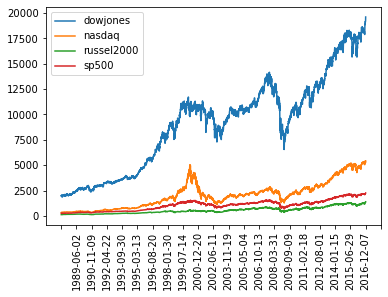

In [107]:
plot_price_data([dowjones, nasdaq, russel2000, sp500],
                ["dowjones", "nasdaq", "russel2000", "sp500"])

# 2. Step 2

# 3. Step 3

# 4. Step 4

### 4.1 Looking at log-returns and percent changes rather than absolute values

https://mathbabe.org/2011/08/30/why-log-returns/

https://quantivity.wordpress.com/2011/02/21/why-log-returns/